# Low-thrust transfers via indirect methods

In this notebook we show how to solve the minimum mass Optimal Control Problem (OCP) for a fixet low-thrust interplanetary transfer employing an indirect method.

Indirect methods are basically following the same template: starting from the dynamics an augmented system of ODE is built applying Pontryagin maximum (minimum, in our case) principle. A Two Point Boundary Value Problem is hence defined on the derived augmented system and solved by means of single or multiple shooting.

In this notebook we guide, step-by-step, the reader in the application of such a method in a widely encountered case in space flight mechanics, and eventually use `pykep` native tools to quickly skip the tedious parts.

In [1]:
import pykep as pk
import numpy as np
import heyoka as hy
import pygmo as pg
import pygmo_plugins_nonfree as ppnf

from matplotlib import pyplot as plt

## Manual construction of the TPBVP
We consider the dynamics:

$$
\left\{
\begin{array}{l}
\dot{\mathbf r}  = \mathbf v \\
\dot{\mathbf v} = -\frac{mu}{r^3}\mathbf r + c_1 \frac um \hat{\mathbf i}\\
\dot{m} = - c_2 u
\end{array}
\right.
$$
where $c_1=T_{max}$ is the maximum thrust that the spacecarft propulsion can deliver, while $c_2 = \frac{T_{max}}{I_{sp} g_0}$.

We also introduce as many auxiliary functions $\mathbf \lambda$ (the co-states) are there are state variables. Using `heyoka` as a symbolic manipulator, let us introduce symbols for all the time dependent quantities:

In [2]:
# The state
x, y, z, vx, vy, vz, m = hy.make_vars("x", "y", "z", "vx", "vy", "vz", "m")
# The costate
lx, ly, lz, lvx, lvy, lvz, lm = hy.make_vars(
    "lx", "ly", "lz", "lvx", "lvy", "lvz", "lm"
)
# The controls
u, ix, iy, iz = hy.make_vars("u", "ix", "iy", "iz")

As to write comfortably the various developments, we introduce some useful expressions and regroup some of our variable into 3D vectors:

In [3]:
# Useful expressions
r3 = (x**2 + y**2 + z**2) ** (1.5)
lv_norm = hy.sqrt(lvx**2 + lvy**2 + lvz**2)
rho = 1 - hy.par[1] * lv_norm / m / hy.par[4] - hy.par[2] * lm / hy.par[4]

# Vectors for convenience of math manipulation
lr = np.array([lx, ly, lz])
lv = np.array([lvx, lvy, lvz])
r = np.array([x, y, z])
v = np.array([vx, vy, vz])
i_vers = np.array([ix, iy, iz])

Note that various constants of our problem are considered as heyoka parameters in the following order: $[\mu, c_1, c_2, \epsilon, \lambda_0]$, $c_1 = T_{max}$, $c_2 = \frac{T_{max}}{I_{sp}g_0}$

The dynamics can then be written as:

In [4]:
# Dynamics
fr = v
fv = hy.par[1] * u / m * i_vers - (hy.par[0] / r3) * r
fm = -hy.par[2] * u

We introduce the Hamiltonian ($\mathbf x$ is the whole state, $\mathbf \lambda$ is the whole co-state, and $\mathbf u$ represent are all the controls), 

$$
\mathcal H(\mathbf x, \mathbf \lambda, \mathbf u) = \mathbf \lambda_r \cdot \mathbf f_r + \mathbf \lambda_v \cdot \mathbf f_v + \lambda_m  f_m + \lambda_0 \left(u + \epsilon\log(u(1-u))\right)
$$

In [5]:
# Hamiltonian
H_full = lr @ fr + lv @ fv + lm * fm + hy.par[4] * (u - hy.par[3] * hy.log(u * (1 - u)))

And write the resulting Hamiltonian system:

$$
\left\{
\begin{array}{l}
\dot{\mathbf x} = \frac{\partial \mathcal H}{\partial \mathbf \lambda} \\
\dot{\mathbf \lambda} = - \frac{\partial \mathcal H}{\partial \mathbf x} \\
\end{array}\right.
$$

In [6]:
# Augmented equations of motion
rhs = [
    hy.diff(H_full, var)
    for var in [lx, ly, lz, lvx, lvy, lvz, lm, x, y, z, vx, vy, vz, m]
]
for j in range(7, 14):
    rhs[j] = -rhs[j]

The minimum principle from Pontryagin requires to find the mimimum in the admissible control space of the Hamiltonian:

$$
\mathbf u^* = \argmin_{\mathbf u \in \mathcal U} \mathcal H(\mathbf x, \mathbf \lambda, \mathbf u)
$$

which, in our case, results in:

In [7]:
# We apply Pontryagin minimum principle (primer vector and u^* = 2eps / (rho + 2eps + sqrt(rho^2+4*eps^2)))
argmin_H_full = {
    ix: -lvx / lv_norm,
    iy: -lvy / lv_norm,
    iz: -lvz / lv_norm,
    u: 2
    * hy.par[3]
    / (rho + 2 * hy.par[3] + hy.sqrt(rho * rho + 4 * hy.par[3] * hy.par[3])),
}

Thanks to the above relations, the control is now a continuous differentiable function of the states and costates and thus the dynamics as well as the Hamiltonian can be reworked: 

In [8]:
rhs = hy.subs(rhs, argmin_H_full)

# We also build the Hamiltonian as a function of the state / co-state only
# (i.e. no longer of controls now solved thanks to the minimum principle)
H = hy.subs(H_full, argmin_H_full)

The following code block thus instantiate the heyoka integrator as well as other convenience functions for later analysis.

In [9]:
# We compile the Hamiltonian into a C function (to be called with pars = [mu, c1, c2, eps, l0])
H_func = hy.cfunc([H], [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm])
# We compile the thrust direction
u_func = hy.cfunc(
    [argmin_H_full[u]], [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm]
)
# We compile the SF
rho_func = hy.cfunc([rho], [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm])
# We compile also the thrust direction
i_vers_func = hy.cfunc(
    [argmin_H_full[ix], argmin_H_full[iy], argmin_H_full[iz]], [lvx, lvy, lvz]
)
# We assemble the Taylor adaptive integrator
full_state = [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm]
sys = [(var, dvar) for var, dvar in zip(full_state, rhs)]
ta = hy.taylor_adaptive(sys, state=[1.0] * 14)

## Constructing the TPBVP using pykep

For the specific case outlined above pykep offers a convenient series of pre-assembled functions and objects which basically construct the same objects as above:

In [10]:
# The Taylor integrator
ta = pk.ta.get_pc(1e-16)
# The Hamiltonian
H_func = pk.ta.get_pc_H_cfunc()
# The switching function
SF_func = pk.ta.get_pc_SF_cfunc()
# The magnitude of the throttle
u_func = pk.ta.get_pc_u_cfunc()
# The thrust direction
i_vers_func = pk.ta.get_pc_i_vers_cfunc()

## Solving in single shooting

We use, as a test case, a simple transfer between two orbits at 1AU. The transfer is simple enough to allow fast convergence and to directly go for a mass optimal trajectory, without using continuation, so that: $\epsilon << 1$.

For convenience and comparison, we also leave a second case commented out where, insted, homotopy would be needed. This case has an $\epsilon$ of $0.1$, which is not mass optimal. Using lower values directly will result in no convergence.

In [11]:
# Testcase 1 (easy, no homotopy)
posvel0 = [
    [34110913367.783306, -139910016918.87585, -14037825669.025244],
    [29090.9902134693, 10000.390168313803, 1003.3858682643288],
]
posvelf = [
    [-159018773159.22266, -18832495968.945133, 15781467087.350443],
    [2781.182556622003, -28898.40730995848, -483.4533989771214],
]
tof = 250
mu = pk.MU_SUN
eps = 1e-4

We instantiate the shooting method using the UDP provided by `pykep`:

In [12]:
udp = pk.trajopt.pontryagin_cartesian(
    posvel0=posvel0,
    posvelf=posvelf,
    tof=tof,
    mu=mu,
    eps=eps,
    T_max=0.6,
    Isp=3000,
    m0=1500,
    L=pk.AU,
    TIME=pk.YEAR2DAY * pk.DAY2SEC,
    MASS=1500,
    with_gradient=True,
)
prob = pg.problem(udp)
prob.c_tol = 1e-6

To solve this problem, we can use both SPQ methods and interior point methods. In this notebook, we make use of the widely available IPOPT solver, which has the great advantage to be also be fully open-source.

In [13]:
ip = pg.ipopt()
ip.set_numeric_option("tol", 1e-9)  # Change the relative convergence tolerance
ip.set_integer_option("max_iter", 50)  # Change the maximum iterations
ip.set_integer_option("print_level", 0)  # Makes Ipopt unverbose
ip.set_string_option(
    "nlp_scaling_method", "none"
)  # Removes any scaling made in auto mode
ip.set_string_option(
    "mu_strategy", "adaptive"
)  # Alternative is to tune the initial mu value
algo = pg.algorithm(ip)

To solve the problem we use a loop, since this is in genral a good practice. In this specific case convergence is immediate and the loop would not be strictly necessary.

In [14]:
masses = []
xs = []
for i in range(30):
    pop = pg.population(prob, 1)
    pop = algo.evolve(pop)
    if prob.feasibility_f(pop.champion_f):
        print(". Success!!", end="")
        udp.fitness(pop.champion_x)
        xs.append(pop.champion_x)
        masses.append(udp.ta.state[6])
        break
    else:
        print("x", end="")
print(f"\nFinal mass is: {masses[0]*udp.MASS} \n")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

. Success!!
Final mass is: 1259.8614050034369 



## Homotopy

The case above was easy for our single shooting technique. In may cases, especially when multiple revolutions appear or intricate switching functions describe the optimal solution, this will not be the case.
In that case homotopy methods can help t find a solution.

Here we show how to implement such methods. We use, as test case, a less easy case (coming from an Earth-Mars transfer) where solving directly for mass optimality ($\epsilon = 1e-4$ would not work).

The condiftions are as follows:

In [15]:
# Testcase 2 (less easy, homotopy needed) [Earth-Mars]
posvel0 = [
    [-125036811000.422, -83670919168.87277, 2610252.8064399767],
    [16081.829029183446, -24868.923007449284, 0.7758272135425942],
]
posvelf = [
    [-169327023332.1986, -161931354587.78766, 763967345.9733696],
    [17656.297796509956, -15438.116653052988, -756.9165272457421],
]
tof = 550
mu = pk.MU_SUN
eps = 1e-1

## Exponential homotopy on $\epsilon$
Here we decrease the $\epsilon$ parameter exponentially and use as predictor for the new decision vector, i.e. the various initial co-state values, the old decision vector.

In [16]:
# We instantiate a new optimzation roblem (a pygmo UDP) with the new parameters:
udp = pk.trajopt.pontryagin_cartesian(
    posvel0=posvel0,
    posvelf=posvelf,
    tof=tof,
    mu=mu,
    eps=eps,
    T_max=0.6,
    Isp=3000,
    m0=1500,
    L=pk.AU,
    TIME=pk.YEAR2DAY * pk.DAY2SEC,
    MASS=1500,
    with_gradient=True,
)
prob = pg.problem(udp)
prob.c_tol = 1e-6

The following code block implements an exponential homotopy over $\epsilon$.

In [17]:
import time
from copy import deepcopy
from IPython.display import clear_output

# No initial guess
first = True
epsilon = 1e-1

# Solve
while True:
    # Set the current epsilon in the udp and construct a problem 
    # (a copy here will be made, so that the udp inside the prob object
    # is a different udp)
    udp.eps = epsilon
    prob = pg.problem(udp)
    prob.c_tol = 1e-6

    # First time looks for a solution, then it continues it
    if first:
        # Creates a random ic population
        pop = pg.population(prob, 1)
        # Starts the time to profile the homotopy time only 
        # (i.e. we exclude the effort to find the first valid traj)
        tstart_tot = time.time()
    else:
        # Use predicted new chromosome
        pop = pg.population(prob)
        pop.push_back(predicted_chromosome)

    # Evolve
    tstart = time.time()
    pop = algo.evolve(pop)
    tend = time.time()

    # Compute constraint violation norm
    err = np.linalg.norm(pop.champion_f[1:])

    # If we find a feasible solution (either the first or a continued one, we log and start the predictor)
    if prob.feasibility_f(pop.champion_f):
        first = False
        clear_output(wait=True)
        print(
            f". Success!! | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | Epsilon = {epsilon:.4e}"
        )

        # Save decision vector for current epsilon (which will be used as an initial guess in the next iteration)
        predicted_chromosome = deepcopy(pop.champion_x)
        best_epsilon = epsilon

        # Save current epsilon (needed if iteration fails)
        epsilon_previous = epsilon

        # Decrease epsilon
        epsilon = epsilon * 0.85

        # Stopping condition (desired epsilon reached)
        if epsilon < 1e-4:
            print(
                f"Desired epsilon reached ! | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | Epsilon = {epsilon:.4e}"
            )
            break

    else:
        clear_output(wait=True)
        print(
            f"x | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | Epsilon = {epsilon:.4e}"
        )

        # If first iteration fails, try again with different initial guess
        if first:
            pass

        # Epsilon is too small, we need to increase it (halfway between previous and current)
        else:
            epsilon_previous_new = epsilon
            epsilon = epsilon + abs(epsilon_previous - epsilon) / 2
            epsilon_previous = epsilon_previous_new
tend_tot = time.time()
print(f"Total CPU time: {tend_tot - tstart_tot:.2e}")

. Success!! | Error: 7.21e-12 | CPU time: 1.64e-01 | Epsilon = 1.0854e-04
Desired epsilon reached ! | Error: 7.21e-12 | CPU time: 1.64e-01 | Epsilon = 9.2260e-05
Total CPU time: 3.83e+00


We could obtain a better total computational time if we could just use a higher exponential decrease factor ... but we cannot as 
this initial guess (the predictor) is poor, so that we are stuck with this. (you can try to decrease the $0.85$ and will see how its always rejected, triggering the code that increases $\epsilon$$)

Let us plot what we found ...

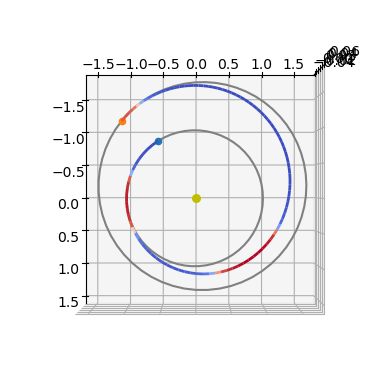

In [18]:
ax3D = udp.plot_trajectory(pop.champion_x)
ax3D.view_init(90, 0)

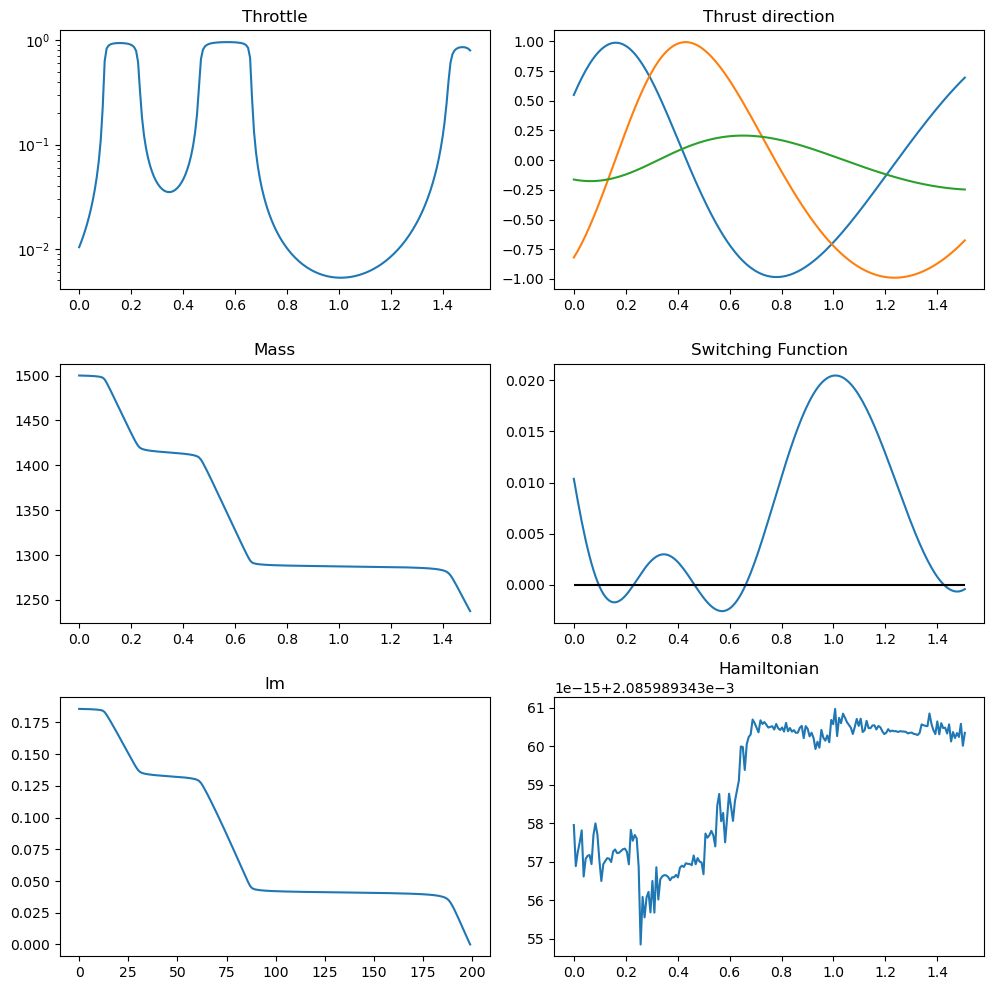

In [19]:
udp.plot_misc(pop.champion_x, N=200);

## Pseudo-arc length continuation

Here we decrease the $\epsilon$ parameter exponentially and use as predictor the tangent vector along the solution curve. This technique is
also known as pseudo-arc continuation. In our case the details are as follows. Assume the final constraints of TPBVB to be indicated with:

$$
\mathbf c(\mathbf \lambda, \epsilon) = 0
$$

where $\mathbf \lambda = [\lambda_x, ..., \lambda_0]$. When $\epsilon$ is changed slightly so must $\mathbf \lambda$ change:

$$
\mathbf c(\mathbf \lambda + \delta\mathbf\lambda, \epsilon + \delta\epsilon) = 0
$$
In the linear world this is:
$$
\frac{\partial \mathbf c}{\partial \mathbf \lambda}\delta\mathbf\lambda + \frac{\partial \mathbf c}{\partial \mathbf \epsilon}\delta\epsilon=0
$$
hence:
$$
\delta \lambda = - \mathbf A^{-1}\mathbf B \delta \epsilon
$$
where $\mathbf A = \frac{\partial \mathbf c}{\partial \mathbf \lambda}$ and $\mathbf B = \frac{\partial \mathbf c}{\partial \mathbf \epsilon}$.
Since the constraints are given directly on values of the final state, the matrices above can be computed seamlessly from a variational Taylor system. Only the last constraint $|\lambda_0|$ is a exception but its gradient is also easily computed.

So lets build a variational integrator that helps here. `pykep` has the dynamics at hand in its `pykep.ta` module. We need to build a first order integrator to study variation of the variables: $[\lambda_x, \lambda_y, \lambda_z, \lambda_{vx}, \lambda_{vy},\lambda_{vz}, \lambda_{m}, \lambda_{0}, \epsilon]$.

In [20]:
sys = pk.ta.pc_dyn()
lx, ly, lz, lvx, lvy, lvz, lm = hy.make_vars("lx", "ly", "lz", "lvx", "lvy", "lvz", "lm")
var_sys = hy.var_ode_sys(sys, [lx, ly, lz, lvx, lvy, lvz, lm, hy.par[4], hy.par[3]])
ta_var = hy.taylor_adaptive(var_sys, compact_mode = True)
ic_var = deepcopy(ta_var.state[14:])

We use the following small helper function to se the state for this new variational integrator, from some chromosome.

In [21]:
def set_ta_var_state(udp, x, ta_var, ic_var):
    # Preparing the numerical integration parameters
    ta_var.pars[0] = udp.mu
    ta_var.pars[1] = udp.c1
    ta_var.pars[2] = udp.c2
    ta_var.pars[3] = udp.eps
    ta_var.pars[4] = x[7]
    ta_var.time = 0.0

    # And initial conditions
    ta_var.state[:3] = udp.posvel0[0]
    ta_var.state[3:6] = udp.posvel0[1]
    ta_var.state[6] = udp.m0
    ta_var.state[7:14] = x[:7]
    ta_var.state[14:] = ic_var

In [22]:
import time
from copy import deepcopy
from IPython.display import clear_output

# No initial guess
first = True
epsilon = 1e-1

# Solve
while True:
    # Set the current epsilon in the udp (for later plotting)
    udp.eps = epsilon
    prob = pg.problem(udp)
    prob.c_tol = 1e-6

    # Random initial guess
    if first:
        # Creates a random ic population
        pop = pg.population(prob, 1)
        tstart_tot = time.time()
    # Use best chromosome from previous iteration
    else:
        pop = pg.population(prob)
        pop.push_back(predicted_chromosome)

    # Evolve
    tstart = time.time()
    pop = algo.evolve(pop)
    tend = time.time()

    # Compute error of fitness vector
    err = np.linalg.norm(pop.champion_f[1:])

    if prob.feasibility_f(pop.champion_f):
        clear_output(wait=True)
        print(
            f". Success!! | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | Epsilon = {epsilon:.4e}"
        )
        
        # Stopping condition (desired epsilon reached)
        if epsilon < 1e-4:
            print(
                f"Desired epsilon reached ! | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | Epsilon = {epsilon:.4e}"
            )
            predicted_chromosome = deepcopy(pop.champion_x)
            break

        # Save decision vector for current epsilon (which will be used as an initial guess in the next iteration)
        predicted_chromosome = deepcopy(pop.champion_x)
        first = False
        best_epsilon = epsilon
        
        # Compute tangent vector
        set_ta_var_state(udp, pop.champion_x, ta_var, ic_var)
        ta_var.propagate_until(udp.tof)

        #Pseudo arc-continuation
        set_ta_var_state(udp, predicted_chromosome, ta_var, ic_var)
        ta_var.propagate_until(udp.tof);
        A =np.zeros((8,8))
        B = np.zeros((8,1))
        # Filling up the constraints on final state
        for i, component in enumerate([0,1,2,3,4,5,13]):
            slice = ta_var.get_vslice(order = 1, component = component)
            B[i,0] = ta_var.state[slice][-1]
            A[i, :] = ta_var.state[slice][:-1]
        # Filling up the constraints norm of lambda
        A[7,:] = 2*predicted_chromosome
        dx = np.ravel(- np.linalg.inv(A) @ B)

        # Save current epsilon (needed if next iteration fails)
        epsilon_previous = epsilon

        # Decrease epsilon
        f_decrease = 0.75
        predicted_chromosome = predicted_chromosome + dx * epsilon * (f_decrease-1)
        epsilon = epsilon * f_decrease

    else:
        clear_output(wait=True)
        print(
            f"x | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | Epsilon = {epsilon:.4e}"
        )

        # If first iteration fails, try again with different initial guess
        if first:
            pass

        # Epsilon is too small, we need to increase it (halfway between previous and current)
        else:
            epsilon_previous_new = epsilon
            epsilon = epsilon + abs(epsilon_previous - epsilon) / 2
            epsilon_previous = epsilon_previous_new
tend_tot = time.time()
print(f"Total CPU time: {tend_tot - tstart_tot:.2e}")


. Success!! | Error: 1.23e-11 | CPU time: 1.33e-01 | Epsilon = 7.5254e-05
Desired epsilon reached ! | Error: 1.23e-11 | CPU time: 1.33e-01 | Epsilon = 7.5254e-05
Total CPU time: 2.90e+00


We obtained a smoother and faster method as our predictor is much better and allows for a more rapid exponential decrease (i.e. factor $0.75$).